In [1]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from pyswarms.single.global_best import GlobalBestPSO

In [3]:
# Cargar el dataset
fichero_DemandaDiaria = "/Users/administrador/Desktop/Ingenieria Informatica UPSA/Curso 3/Prediccion Demanda Electrica/Datos/DemandaDiaria_KWh_2015-2021.csv"
data = pd.read_csv(fichero_DemandaDiaria, sep=";")
data['Date'] = pd.to_datetime(data['Date'])  # Convertir la columna de fecha a tipo datetime
data = data.set_index('Date')  # Establecer la columna de fecha como índice

# Preprocesamiento de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Load'].values.reshape(-1, 1))

# Dividir los datos en entrenamiento y prueba
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Crear secuencias de entrenamiento
def create_sequences(dataset, sequence_length):
    X, y = [], []
    for i in range(len(dataset) - sequence_length):
        X.append(dataset[i:i + sequence_length, 0])
        y.append(dataset[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 10  # Longitud de la secuencia de entrada
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [4]:
# Definir la función objetivo para la optimización
def objective_function(params):
    return svr_cost(params)

# Definir la función de costo para la SVR
def svr_cost(params):
    n_particles = params.shape[0]
    costs = np.zeros(n_particles)
    for i in range(n_particles):
        if len(params[i]) == 1:
            C = float(params[i][0])  # Convertir a flotante
            if C <= 0.0:
                C = 0.1  # Valor predeterminado si C es no válido
            model = SVR(kernel='rbf', C=C)
        elif len(params[i]) == 2:
            C, gamma = map(float, params[i])  # Convertir a flotantes
            if C <= 0.0:
                C = 0.1  # Valor predeterminado si C es no válido
            model = SVR(kernel='rbf', C=C, gamma=gamma)
        else:
            raise ValueError("Invalid number of parameters")
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
        costs[i] = rmse
    
    return costs

In [13]:
# Optimizar 'C'
# No todos los valores de C son válidos
bounds = ( [0.001], [10] )
optimizer_c = GlobalBestPSO(n_particles=10, dimensions=1, options={"c1": 0.5, "c2": 0.3, "w": 0.9}, bounds=bounds)
best_cost_c, best_params_c = optimizer_c.optimize(objective_function, iters=50)

# Obtener el valor óptimo de 'C'
if isinstance(best_params_c, (list, np.ndarray)):
    C_opt = best_params_c[0]
else:
    C_opt = best_params_c


# Optimizar 'gamma'
bounds = ( np.array( [0.001, 0.01]), np.array( [10.0, 10.0] ) )
# gamma_options = ('scale', 'auto')
optimizer_gamma = GlobalBestPSO(n_particles=10, dimensions=2, options={"c1": 0.5, "c2": 0.3, "w": 0.9}, bounds= bounds)
best_cost_gamma, best_params_gamma = optimizer_gamma.optimize(objective_function, iters=50)

# Obtener el valor óptimo de 'gamma'
C_opt_gamma = best_params_gamma[0]
gamma_opt = best_params_gamma[1]


2023-06-06 19:28:54,475 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=2.58e+8
2023-06-06 19:29:22,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 258294869.45938456, best pos: [0.27038357]
2023-06-06 19:29:22,862 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=2.47e+8
2023-06-06 19:29:53,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 247040873.87702262, best pos: [5.80391642 0.47112433]


0.2703835726157061
5.803916419263741


In [14]:
# Crear y entrenar el modelo con los mejores hiperparámetros encontrados
best_model = SVR(kernel='rbf', C=C_opt_gamma, gamma=gamma_opt)
best_model.fit(X_train, y_train)

SVR(C=5.803916419263741, gamma=0.4711243316625069)

In [15]:
# Predecir los valores de y
y_pred = best_model.predict(X_test)
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calcular los errores
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()  # Definir y_test_orig
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mrae = mae / np.mean(y_test_orig)

# Imprimir los errores
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Relative Absolute Error (MRAE):", mrae)


Mean Absolute Error (MAE): 176637767.24356228
Root Mean Squared Error (RMSE): 247040873.87702262
Mean Relative Absolute Error (MRAE): 0.026673042137007896


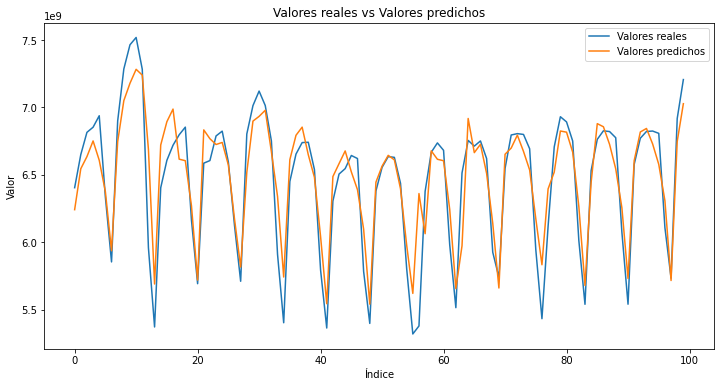

In [16]:
# Representar los valores reales y predichos
start_index = 0
end_index = 100

plt.figure(figsize=(12, 6))
plt.plot(y_test_orig[start_index:end_index], label='Valores reales')
plt.plot(y_pred_orig[start_index:end_index], label='Valores predichos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores reales vs Valores predichos')
plt.legend()
plt.show()